### <font color = 'green'> Preparación de entorno

In [1]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

##### CONFIGURACIÓN DE ENTORNO #####
from google.colab import drive     # Conectar Google drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Trabajos_UNALM/I.O.A./P2_IOA/'  # Directorio de trabajo (cambiar aquí)
os.chdir(path)    # Seleccionar carpeta de trabajo

Mounted at /content/drive/


Descarga de librerías

In [2]:
%%capture
!pip install 'cartopy==0.18.0'
!pip install shapely --no-binary shapely --force
!pip install geopandas
!pip install 'xarray==0.19.0'
# !pip install rioxarray

### <font color = 'green'> Cálculo de climatología, anomalías y correlación

1. Lectura del dataset CHIRPS 2.0

In [3]:
import xarray as xr, pandas as pd, numpy as np

## Forma de carga mediante el IRIdl (Demasiada resolución del CHIRPS)
# chirps_opendap = 'http://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.monthly/.global/.precipitation/Y/%2815.0N%29%2849.975S%29RANGEEDGES/X/%2890W%29%2820W%29RANGEEDGES/T/%28Jan%201991%29%28Oct%202022%29RANGEEDGES/X/%2885W%29%2820.0W%29RANGEEDGES/Y/%282.5N%29%2820.0S%29RANGEEDGES/X/%2885W%29%2865.0W%29RANGEEDGES/dods'
# pp_CHIRPS = xr.open_dataset(chirps_opendap, decode_times = False)

## Forma de carga directa del nc
pp_CHIRPS = xr.open_dataset(path + 'CHIRPS_PERU_1991-2021.nc', decode_times = False)
pp_CHIRPS['T'] = pd.date_range('1991-01-01', '2022-10-01', freq = 'MS')
pp_CHIRPS

<xarray.Dataset>
Dimensions:        (T: 382, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-01-01 1991-02-01 ... 2022-10-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
Data variables:
    precipitation  (T, Y, X) float32 ...

2. Climatología mensual 1991-2020

In [5]:
pp_CHIRPS_clim = pp_CHIRPS.sel(T = slice('1991-01-01T00:00:00.000000000','2020-12-31T00:00:00.000000000'))\
                            .groupby('T.month').mean('T')     # Climatología mensual
pp_CHIRPS_clim

<xarray.Dataset>
Dimensions:        (Y: 450, X: 401, month: 12)
Coordinates:
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precipitation  (month, Y, X) float32 nan nan nan nan ... 89.46 85.92 86.13

2. Anomalía mensual

In [6]:
pp_CHIRPS_anom = pp_CHIRPS.groupby('T.month') - pp_CHIRPS_clim     # Anomalías mensuales
pp_CHIRPS_anom

<xarray.Dataset>
Dimensions:        (T: 382, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-01-01 1991-02-01 ... 2022-10-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
    month          (T) int64 1 2 3 4 5 6 7 8 9 10 11 ... 12 1 2 3 4 5 6 7 8 9 10
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -18.14 -18.07 -18.72

3. Climatología estacional/trimestral 1991-2020

In [7]:
pp_CHIRPS_clim_seasonal = pp_CHIRPS.sel(T = slice('1991-01-01T00:00:00.000000000','2020-12-31T00:00:00.000000000'))\
                                    .groupby('T.season').mean('T')   # Climatología estacional
pp_CHIRPS_clim_seasonal

<xarray.Dataset>
Dimensions:        (Y: 450, X: 401, season: 4)
Coordinates:
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, Y, X) float32 nan nan nan nan ... 35.63 35.76 36.23

4. Anomalías estacionales

In [8]:
pp_CHIRPS_anom_seasonal = pp_CHIRPS_anom.resample(T = 'QS-Mar').mean()  # Anomalías estacionales
pp_CHIRPS_anom_seasonal

<xarray.Dataset>
Dimensions:        (T: 128, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1990-12-01 1991-03-01 ... 2022-09-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -11.42 -11.4 -12.02

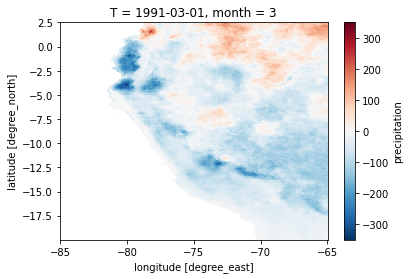

In [ ]:
pp_CHIRPS_anom_seasonal.isel(T = 1, month = 2).precipitation.plot()

5. Carga de datos de anomalías de TSM (Informe anterior)

In [9]:
from datetime import datetime

Anom_month  = pd.read_csv('/content/drive/MyDrive/Trabajos_UNALM/I.O.A./P1_IOA/'+'Anom_Niño_monthly.txt', sep = ',', index_col = [0], parse_dates = True)
Anom_season = pd.read_csv('/content/drive/MyDrive/Trabajos_UNALM/I.O.A./P1_IOA/'+'Anom_Niño_seasonal.txt', sep = ',', index_col = [0], parse_dates = True)

Anom_month.index.set_names('T', inplace = True)     
Anom_season.index.set_names('T', inplace = True)

mask_CI = (datetime(1991,1,1) <= Anom_month.index) & (Anom_month.index <= datetime(2020,12,31))
Anom_month = Anom_month.loc[mask_CI]

mask_CI = (datetime(1991,1,1) <= Anom_season.index) & (Anom_season.index <= datetime(2020,12,31))
Anom_season = Anom_season.loc[mask_CI]

In [10]:
Anom_season

,N1+2,N3,N4,N3.4
T,,,,
1991-03-31,-0.201729,0.039526,0.568709,0.350660
1991-06-30,-0.257349,0.025835,0.385943,0.173138
1991-09-30,0.246475,0.486061,0.389837,0.477317
1991-12-31,0.489055,0.576999,0.466993,0.704253
1992-03-31,0.422254,1.287893,0.717979,1.608432
...,...,...,...,...
2019-12-31,-0.373090,0.082616,0.639630,0.411869
2020-03-31,-0.105569,0.260278,0.759202,0.517611
2020-06-30,-0.239662,-0.040322,0.369355,0.167409


6. Cálculo del coeficiente de correlación de Spearman

In [11]:
def Spearman_corr(x,y):
    from scipy.stats import spearmanr
    r,p = spearmanr(x,y)
    return r

CHIRPS_corr = pp_CHIRPS_anom.sel(T = slice('1991-01-01T00:00:00.000000000','2020-12-31T00:00:00.000000000'))
for sec in Anom_season.columns:
    CHIRPS_corr[f'Rho_{sec}'] = xr.apply_ufunc(Spearman_corr,
                                                CHIRPS_corr.precipitation,
                                                Anom_month[sec].values,
                                                input_core_dims = [["T"],['T']],
                                                vectorize = True)
CHIRPS_corr

<xarray.Dataset>
Dimensions:        (T: 360, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
    month          (T) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -22.29 -18.62 -16.31
    Rho_N1+2       (Y, X) float64 nan nan nan ... -0.01364 -0.005896 -0.00296
    Rho_N3         (Y, X) float64 nan nan nan nan ... 0.01616 0.03386 0.03584
    Rho_N4         (Y, X) float64 nan nan nan nan ... 0.03367 0.05614 0.05092
    Rho_N3.4       (Y, X) float64 nan nan nan nan ... 0.03761 0.05857 0.05722

### <font color = 'green'> Gráficos para el informe

In [12]:
import matplotlib.pyplot as plt, matplotlib.ticker as mticker,matplotlib.dates as mdates, cartopy.crs as ccrs
from cartopy.feature import BORDERS, OCEAN, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

projection = ccrs.PlateCarree()
mes = {1:'ENERO',2:'FEBRERO',3:'MARZO',4:'ABRIL',5:'MAYO',6:'JUNIO',
       7:'JULIO',8:'AGOSTO',9:'SETIEMBRE',10:'OCTUBRE',11:'NOVIEMBRE',12:'DICIEMBRE'}
season = {1:'Verano - DEF',2:'Invierno - JJA',3:'Otoño - MAM',4:'Primavera - SON'}

Climatología mensual 1991-2020 del CHIRPS

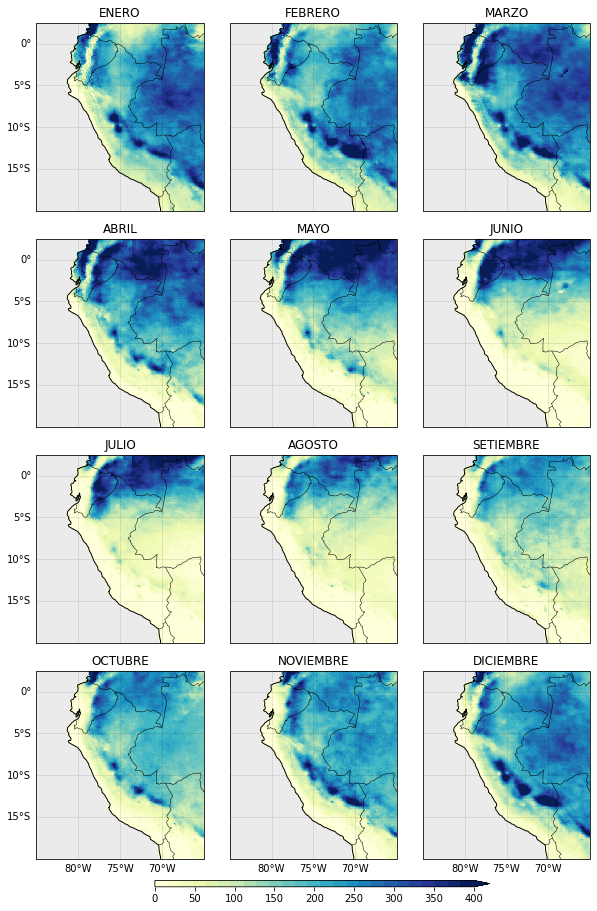

In [13]:
# https://nbviewer.org/github/irenemeanspeace/phirad/blob/master/visualization/Precipitation%20with%20different%20colormaps.ipynb?flush_cache=true
cmap = plt.get_cmap('YlGnBu', 25)
cmap.set_bad('#EBEBEB')

plot = pp_CHIRPS_clim.precipitation.plot(x='X', y='Y', col='month', col_wrap=3, figsize = (10,18),   # Plot horizontal 3x3
                         subplot_kws = {"projection": projection}, 
                         cmap = cmap, vmin = 0, vmax = 400,
                         cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'shrink':0.6, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
    ax.coastlines('50m')
    ax.set_title(mes[i+1])

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0, 3, 6, 9]:  grids.ylabels_left = False
    if i not in [9, 10, 11]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
    grids.ylocator = mticker.FixedLocator([y for y in range(-20, 0+5,5)])    # labels y
    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER
    ax.margins(x = 0, y = 0)

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.15)

plot.fig.savefig(path + f'pp_CHIRPS_1991-2020.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

Climatología estacional 1991-2020

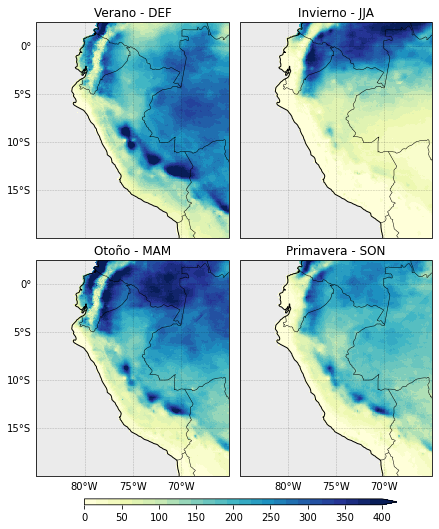

In [14]:
cmap = plt.get_cmap('YlGnBu', 25)
cmap.set_bad('#EBEBEB')

plot = pp_CHIRPS_clim_seasonal.precipitation.plot(x='X', y='Y', col='season', col_wrap=2, figsize = (7,10),
                         subplot_kws = {"projection": projection}, 
                         cmap = cmap, vmin = 0, vmax = 400,
                         cbar_kwargs={'orientation':'horizontal', 'pad':0.02, 'shrink':0.8, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
    ax.coastlines('50m')
    ax.set_title(season[i+1])

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0,2]:  grids.ylabels_left = False
    if i in [0,1]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
    grids.ylocator = mticker.FixedLocator([y for y in range(-20, 0+5,5)])    # labels y
    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

    ax.margins(x = 0, y = 0)

plt.subplots_adjust(bottom = 0.27, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.1)

plot.fig.savefig(path + f'CHIRPS_Climatology_season_1991-2020.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

Anomalía mensual de precipitación

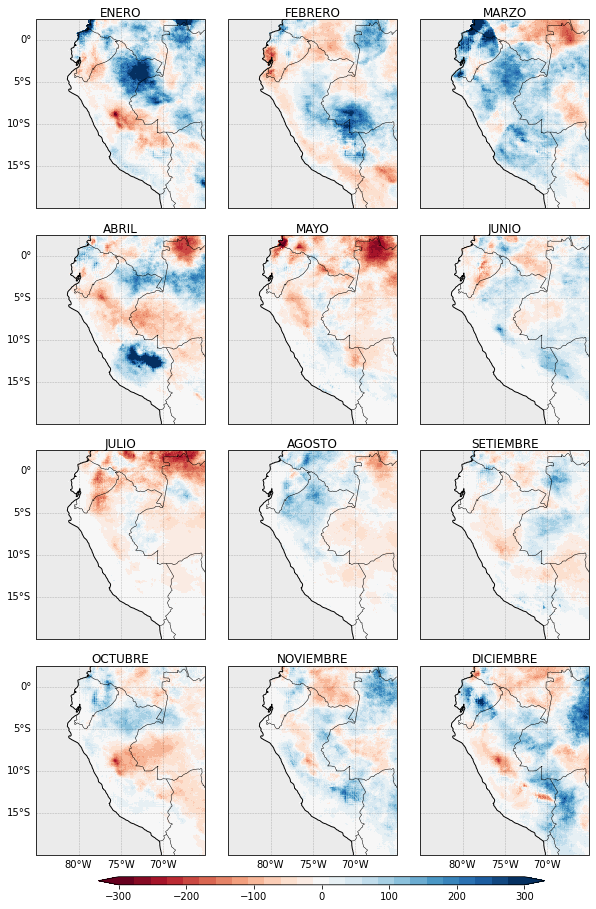

In [15]:
cmap = plt.get_cmap('RdBu', 25)
cmap.set_bad('#EBEBEB')

year = 2021     # Seleccionar año
ds = pp_CHIRPS_anom.sel(T = slice(f'{year}-01-01T00:00:00.000000000',f'{year}-12-31T00:00:00.000000000'))\
                    .groupby('T.month').mean('T')

plot = ds.precipitation.plot(x='X', y='Y', col='month', col_wrap=3, figsize = (10,18),   # Plot vertical 6x2
                    subplot_kws = {"projection": projection}, 
                    cmap = cmap, vmin = -300, vmax = 300,
                    cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'shrink':0.8, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
    ax.coastlines('50m')
    ax.set_title(mes[i+1], pad = 2)

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0, 3, 6, 9]:  grids.ylabels_left = False
    if i not in [9, 10, 11]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])    # labels x
    grids.ylocator = mticker.FixedLocator([y for y in range(-20, 0+5,5)])    # labels y
    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

    ax.margins(x = 0, y = 0)

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.0, hspace = 0.14)

plot.fig.savefig(path + f'CHIRPS_Anom_M_{year}.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

Anomalía estacional de precipitación

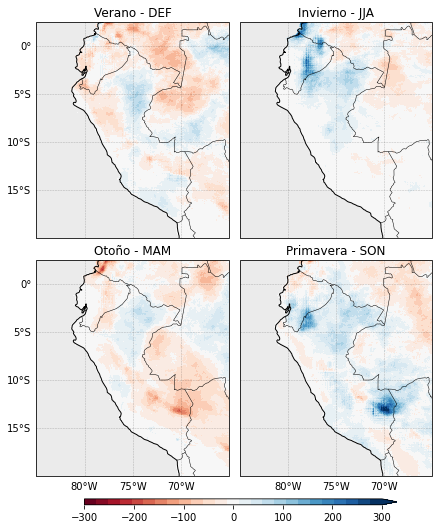

In [16]:
cmap = plt.get_cmap('RdBu', 25)
cmap.set_bad('#EBEBEB')

year = 2020     # Seleccionar año
ds = pp_CHIRPS_anom_seasonal.sel(T = slice(f'{year-1}-12-01T00:00:00.000000000',f'{year}-09-01T00:00:00.000000000'))\
                    .groupby('T.month').mean('T')

plot = ds.precipitation.plot(x='X', y='Y', col='month', col_wrap=2, figsize = (7,10),   # Plot vertical 6x2
                    subplot_kws = {"projection": projection}, 
                    cmap = cmap, vmin = -300, vmax = 300,
                    cbar_kwargs={'orientation':'horizontal', 'pad':0.02, 'shrink':0.8, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
    ax.coastlines('50m')
    ax.set_title(season[i+1])

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0,2]:  grids.ylabels_left = False
    if i in [0,1]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
    grids.ylocator = mticker.FixedLocator([y for y in range(-20, 0+5,5)])    # labels y
    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

    ax.margins(x = 0, y = 0)

plt.subplots_adjust(bottom = 0.27, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.1)

plot.fig.savefig(path + f'CHIRPS_Anom_T_{year}.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

Coeficiente de correlación de Speraman

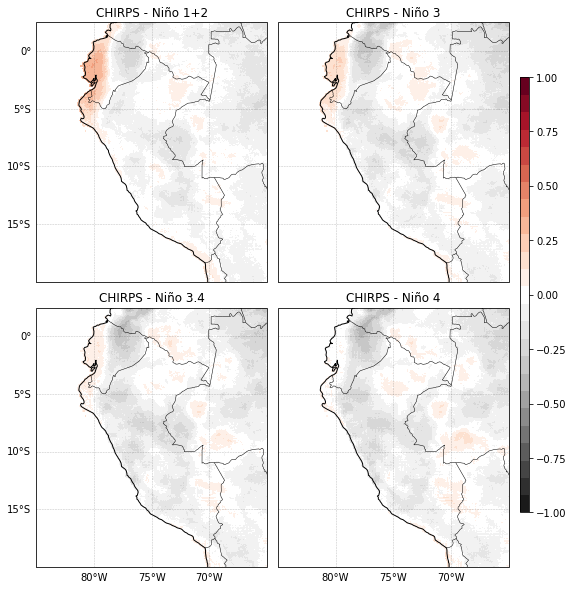

In [18]:
subplot_kws = {'projection': ccrs.PlateCarree(), 
               'facecolor':'white', 'aspect':'equal'}
cmap = plt.get_cmap('RdGy_r', 25)

fig, Ax = plt.subplots(2,2,figsize = (10,12), subplot_kw = subplot_kws)

Sector_name = {0:'Niño 1+2',1:'Niño 3',2:'Niño 3.4',3:'Niño 4'}
for i, ax, sec in zip([0,1,2,3], Ax.flatten(), ['Rho_N1+2','Rho_N3','Rho_N3.4','Rho_N4']):
    plot = CHIRPS_corr[sec].plot(x='X', y='Y', ax = ax, add_colorbar=False,
                                 cmap = cmap, vmin = -1, vmax = 1)
    
    ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
    ax.coastlines('50m')
    ax.set_title(f'CHIRPS - {Sector_name[i]}')

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0,2]:  grids.ylabels_left = False
    if i in [0,1]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
    grids.ylocator = mticker.FixedLocator([y for y in range(-20, 0+5,5)])    # labels y
    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER
    ax.margins(x = 0, y = 0)

plt.subplots_adjust(bottom = 0.27, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.1)
fig.colorbar(plot, ax = Ax, **{'orientation':'vertical', 'pad':0.02, 'shrink':0.8, 'aspect':50, 'label':''})

fig.savefig(path + f'CHIRPS_corr.png', 
            transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')